In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import math
from scipy import ndimage, misc

from sklearn import svm
from sklearn.metrics import confusion_matrix

## 0 数据预准备

In [3]:
datasets_path = "D:/NUS/NUS_academic/MER_Project_Code/"
data_path = os.path.join(datasets_path, "Cropped")
label_path = os.path.join(datasets_path, "Tag")
HoF_feature_path = "D:/NUS/NUS_academic/MER_Project_Code/hof_feature_all.npy"
LBP_feature_path = "D:/NUS/NUS_academic/MER_Project_Code/lbp_feature_all.npy"
Label_path = "D:/NUS/NUS_academic/MER_Project_Code/Label.npy"

In [56]:
os.chdir(label_path)
orig_dir = os.getcwd()
print(orig_dir)

os.chdir(data_path)
orig_dir = os.getcwd()
print(orig_dir)

D:\NUS\NUS_academic\Project_Code\Tag
D:\NUS\NUS_academic\Project_Code\Cropped


In [6]:
subject_list = os.listdir(orig_dir)
#print(subject_list)

count = 0
Max_Frames_num = 0
Min_Frames_num = 1000
file_name = []

for subject in subject_list:  # [sub01 ... sub26]
    subject_path_list = os.path.join(orig_dir, subject)
    file_list = os.listdir(subject_path_list)
    file_name.append(file_list)
    #print(file_list)
    count = count + len(file_list)
    for file in file_list:  # [EP...]
        file_path_list = os.path.join(subject_path_list, file)
        img_list = os.listdir(file_path_list)
        
        if Max_Frames_num < len(img_list):
            Max_Frames_num = len(img_list)
            
        if Min_Frames_num > len(img_list):
            Min_Frames_num = len(img_list)   
print(count,Max_Frames_num,Min_Frames_num)   
print(file_name)

255 141 24
[['EP02_01f', 'EP03_02', 'EP04_02', 'EP04_03', 'EP04_04', 'EP19_01', 'EP19_03f', 'EP19_05f', 'EP19_06f'], ['EP01_11f', 'EP02_04f', 'EP03_02f', 'EP06_01f', 'EP06_02f', 'EP08_04', 'EP09_01', 'EP09_06f', 'EP09_10', 'EP11_01', 'EP13_04', 'EP14_01', 'EP15_04'], ['EP01_2', 'EP07_03', 'EP07_04', 'EP08_1', 'EP09_03', 'EP18_06', 'EP19_08'], ['EP12_01f', 'EP12_02f', 'EP13_02f', 'EP13_06f', 'EP19_01f'], ['EP02_07', 'EP03_01', 'EP03_06', 'EP03_07', 'EP04_05', 'EP04_06', 'EP05_03', 'EP05_09', 'EP06_10', 'EP07_01', 'EP08_05', 'EP09_05f', 'EP12_03f', 'EP12_06', 'EP13_04f', 'EP13_06', 'EP16_03f', 'EP16_04f', 'EP19_03'], ['EP01_01', 'EP02_31', 'EP10_08', 'EP15_02', 'EP16_05'], ['EP01_01', 'EP03_04', 'EP06_01', 'EP06_02_01', 'EP06_02_02', 'EP08_02', 'EP15_01', 'EP18_01', 'EP18_03'], ['EP12_07f', 'EP12_08f', 'EP13_01f'], ['EP02_01f', 'EP05_02', 'EP05_03', 'EP05_05', 'EP06_01f', 'EP06_02f', 'EP09f', 'EP09_04', 'EP09_05', 'EP13_01', 'EP13_02', 'EP15_05', 'EP17_08', 'EP18_03'], ['EP06_01f', 'EP08

删除 24 EP02_07 | 9 EP02_02f 两个无标签样本后 
最大帧数 141 最小帧数 24 共有 255 个样本 

In [8]:
def dedimension(array_name):
    tem = str(array_name)
    tem = tem.replace('[','')
    tem = tem.replace(']','')
    array_name = list(eval(tem))
    return array_name

In [9]:
file_name = dedimension(file_name)
file_name

['EP02_01f',
 'EP03_02',
 'EP04_02',
 'EP04_03',
 'EP04_04',
 'EP19_01',
 'EP19_03f',
 'EP19_05f',
 'EP19_06f',
 'EP01_11f',
 'EP02_04f',
 'EP03_02f',
 'EP06_01f',
 'EP06_02f',
 'EP08_04',
 'EP09_01',
 'EP09_06f',
 'EP09_10',
 'EP11_01',
 'EP13_04',
 'EP14_01',
 'EP15_04',
 'EP01_2',
 'EP07_03',
 'EP07_04',
 'EP08_1',
 'EP09_03',
 'EP18_06',
 'EP19_08',
 'EP12_01f',
 'EP12_02f',
 'EP13_02f',
 'EP13_06f',
 'EP19_01f',
 'EP02_07',
 'EP03_01',
 'EP03_06',
 'EP03_07',
 'EP04_05',
 'EP04_06',
 'EP05_03',
 'EP05_09',
 'EP06_10',
 'EP07_01',
 'EP08_05',
 'EP09_05f',
 'EP12_03f',
 'EP12_06',
 'EP13_04f',
 'EP13_06',
 'EP16_03f',
 'EP16_04f',
 'EP19_03',
 'EP01_01',
 'EP02_31',
 'EP10_08',
 'EP15_02',
 'EP16_05',
 'EP01_01',
 'EP03_04',
 'EP06_01',
 'EP06_02_01',
 'EP06_02_02',
 'EP08_02',
 'EP15_01',
 'EP18_01',
 'EP18_03',
 'EP12_07f',
 'EP12_08f',
 'EP13_01f',
 'EP02_01f',
 'EP05_02',
 'EP05_03',
 'EP05_05',
 'EP06_01f',
 'EP06_02f',
 'EP09f',
 'EP09_04',
 'EP09_05',
 'EP13_01',
 'EP13_02',


In [10]:
# 检查标签是否对应
os.chdir(label_path)
Tag_name = pd.read_csv('Tag.csv', usecols=[1]).values.tolist()
Tag_name = dedimension(Tag_name)
Tag_name

['EP02_01f',
 'EP03_02',
 'EP04_02',
 'EP04_03',
 'EP04_04',
 'EP19_01',
 'EP19_03f',
 'EP19_05f',
 'EP19_06f',
 'EP01_11f',
 'EP02_04f',
 'EP03_02f',
 'EP06_01f',
 'EP06_02f',
 'EP08_04',
 'EP09_01',
 'EP09_06f',
 'EP09_10',
 'EP11_01',
 'EP13_04',
 'EP14_01',
 'EP15_04',
 'EP01_2',
 'EP07_03',
 'EP07_04',
 'EP08_1',
 'EP09_03',
 'EP18_06',
 'EP19_08',
 'EP12_01f',
 'EP12_02f',
 'EP13_02f',
 'EP13_06f',
 'EP19_01f',
 'EP02_07',
 'EP03_01',
 'EP03_06',
 'EP03_07',
 'EP04_05',
 'EP04_06',
 'EP05_03',
 'EP05_09',
 'EP06_10',
 'EP07_01',
 'EP08_05',
 'EP09_05f',
 'EP12_03f',
 'EP12_06',
 'EP13_04f',
 'EP13_06',
 'EP16_03f',
 'EP16_04f',
 'EP19_03',
 'EP01_01',
 'EP02_31',
 'EP10_08',
 'EP15_02',
 'EP16_05',
 'EP01_01',
 'EP03_04',
 'EP06_01',
 'EP06_02_01',
 'EP06_02_02',
 'EP08_02',
 'EP15_01',
 'EP18_01',
 'EP18_03',
 'EP12_07f',
 'EP12_08f',
 'EP13_01f',
 'EP02_01f',
 'EP05_02',
 'EP05_03',
 'EP05_05',
 'EP06_01f',
 'EP06_02f',
 'EP09f',
 'EP09_04',
 'EP09_05',
 'EP13_01',
 'EP13_02',


In [13]:
# 检查标签是否一致
i = 0
for item in file_name:
    if item == Tag_name[i]:
        i=i+1
        print(i)
        continue
    print(i)
    break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


In [15]:
# 不一致 转存csv检查
name = ['file_name']
file_name_pd=pd.DataFrame(columns=name,data=file_name)
file_name_pd.to_csv('file_name.csv')

标签已对齐

## 1 提取 LBP_TOP| HOF 特征

### 1.1 HOF 特征 

In [6]:
def hof(flow, orientations=9, pixels_per_cell=(8, 8),
        cells_per_block=(2, 2), normalise=False, motion_threshold=1.):

    """Extract Histogram of Optical Flow (HOF) for a given image.
    Key difference between this and HOG is that flow is MxNx2 instead of MxN
    
    Compute a Histogram of Optical Flow (HOF) by
        1. (optional) global image normalisation
        2. computing the dense optical flow
        3. computing flow histograms
        4. normalising across blocks
        5. flattening into a feature vector
    Parameters
    ----------
    Flow : (M, N) ndarray
        Input image (x and y flow images).
    orientations : int
        Number of orientation bins.
    pixels_per_cell : 2 tuple (int, int)
        Size (in pixels) of a cell.
    cells_per_block  : 2 tuple (int,int)
        Number of cells in each block.
    normalise : bool, optional
        Apply power law compression to normalise the image before
        processing.
    static_threshold : threshold for no motion
    
    Returns
    -------
    newarr : ndarray
        hof for the image as a 1D (flattened) array.
    hof_image : ndarray (if visualise=True)
        A visualisation of the hof image.
    
    References
    ----------
    * http://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
    * Dalal, N and Triggs, B, Histograms of Oriented Gradients for
      Human Detection, IEEE Computer Society Conference on Computer
      Vision and Pattern Recognition 2005 San Diego, CA, USA
    """
    flow = np.atleast_2d(flow)

    """ 
    -1-
    The first stage applies an optional global image normalisation
    equalisation that is designed to reduce the influence of illumination
    effects. In practice we use gamma (power law) compression, either
    computing the square root or the log of each colour channel.
    Image texture strength is typically proportional to the local surface
    illumination so this compression helps to reduce the effects of local
    shadowing and illumination variations.
    """

    if flow.ndim < 3:
        raise ValueError("Requires dense flow in both directions")

    if normalise:
        flow = sqrt(flow)

    """ 
    -2-
    The second stage computes first order image gradients. These capture
    contour, silhouette and some texture information, while providing
    further resistance to illumination variations. The locally dominant
    colour channel is used, which provides colour invariance to a large
    extent. Variant methods may also include second order image derivatives,
    which act as primitive bar detectors - a useful feature for capturing,
    e.g. bar like structures in bicycles and limbs in humans.
    """

    if flow.dtype.kind == 'u':
        # convert uint image to float
        # to avoid problems with subtracting unsigned numbers in np.diff()
        flow = flow.astype('float')

    gx = np.zeros(flow.shape[:2])
    gy = np.zeros(flow.shape[:2])
    
    # gx[:, :-1] = np.diff(flow[:,:,1], n=1, axis=1)
    # gy[:-1, :] = np.diff(flow[:,:,0], n=1, axis=0)

    gx = flow[:,:,1]
    gy = flow[:,:,0]


    """ 
    -3-
    The third stage aims to produce an encoding that is sensitive to
    local image content while remaining resistant to small changes in
    pose or appearance. The adopted method pools gradient orientation
    information locally in the same way as the SIFT [Lowe 2004]
    feature. The image window is divided into small spatial regions,
    called "cells". For each cell we accumulate a local 1-D histogram
    of gradient or edge orientations over all the pixels in the
    cell. This combined cell-level 1-D histogram forms the basic
    "orientation histogram" representation. Each orientation histogram
    divides the gradient angle range into a fixed number of
    predetermined bins. The gradient magnitudes of the pixels in the
    cell are used to vote into the orientation histogram.
    """

    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx) * (180 / math.pi) % 180

    sy, sx = flow.shape[:2]
    cx, cy = pixels_per_cell
    bx, by = cells_per_block

    n_cellsx = int(np.floor(sx // cx))  # number of cells in x
    n_cellsy = int(np.floor(sy // cy))  # number of cells in y

    # compute orientations integral images
    orientation_histogram = np.zeros((n_cellsy, n_cellsx, orientations))
    # 两维 第一维从每个cell中间像素开始 到图片最后一个像素 步长为每个cell的大小
    subsample = np.index_exp[int(cy / 2):cy * n_cellsy:cy, int(cx / 2):cx * n_cellsx:cx]
    
    for i in range(orientations-1):
        #create new integral image for this orientation
        # isolate orientations in this range

        temp_ori = np.where(orientation < 180 / orientations * (i + 1),
                            orientation, -1)
        temp_ori = np.where(orientation >= 180 / orientations * i,
                            temp_ori, -1)
        # select magnitudes for those orientations
        cond2 = (temp_ori > -1) * (magnitude > motion_threshold)
        temp_mag = np.where(cond2, magnitude, 0)

        #temp_filt = uniform_filter(temp_mag, size=(cy, cx))
        temp_filt = ndimage.uniform_filter(temp_mag, size=(cy, cx))
        orientation_histogram[:, :, i] = temp_filt[subsample]

    ''' Calculate the no-motion bin '''
    temp_mag = np.where(magnitude <= motion_threshold, magnitude, 0)

    temp_filt = ndimage.uniform_filter(temp_mag, size=(cy, cx))
    #print("tem_filt shape = ",temp_filt.shape)
    orientation_histogram[:, :, -1] = temp_filt[subsample]
    #print("orientation_histogram shape = ",orientation_histogram.shape)

    """
    The fourth stage computes normalisation, which takes local groups of
    cells and contrast normalises their overall responses before passing
    to next stage. Normalisation introduces better invariance to illumination,
    shadowing, and edge contrast. It is performed by accumulating a measure
    of local histogram "energy" over local groups of cells that we call
    "blocks". The result is used to normalise each cell in the block.
    Typically each individual cell is shared between several blocks, but
    its normalisations are block dependent and thus different. The cell
    thus appears several times in the final output vector with different
    normalisations. This may seem redundant but it improves the performance.
    We refer to the normalised block descriptors as Histogram of Oriented
    Gradient (hog) descriptors.
    """

    n_blocksx = (n_cellsx - bx) + 1
    n_blocksy = (n_cellsy - by) + 1
    normalised_blocks = np.zeros((n_blocksy, n_blocksx,
                                  by, bx, orientations))

    for x in range(n_blocksx):
        for y in range(n_blocksy):
            block = orientation_histogram[y:y+by, x:x+bx, :]
            eps = 1e-5
            normalised_blocks[y, x, :] = block / np.sqrt(block.sum()**2 + eps)

    return normalised_blocks.ravel()

In [7]:
#extract Histogram of Optical Flow features for a given consequetive frames. Replace frame by extracted HOG
#def extract_hof_feature(seq_location_list,seq_label):
def extract_hof_feature(seq_location):
    feature_hof = []
    label_list = []
        
    filepath=seq_location

    seq_folder = os.listdir(filepath)
    #seq_folder_sorted=sorted(seq_folder, key=numericalsort)
    seq_folder_sorted=seq_folder
    hof_hist=[]

    #iterate the frames inside a given sequence
    for b in range(0,len(seq_folder_sorted)-1):
        framepath = os.path.join(filepath, seq_folder_sorted[b])
        #print("image being processed", framepath)
        #read first frame
        frame = cv2.imread(framepath)
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray,dsize=(128,150))

        previousGray = gray

        framepath_next = os.path.join(filepath, seq_folder_sorted[b+1])

        frame_next = cv2.imread(framepath_next)
 

        gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray,dsize=(128,150))


        flow = cv2.calcOpticalFlowFarneback(previousGray, gray, 
                                            flow=None, pyr_scale=0.5, levels=5, winsize=11, 
                                            iterations=10, poly_n=5, poly_sigma=1.1, flags=0)
        """
            pyrScale:   金字塔上下两层之间的尺度关系，该参数一般设置为pyrScale=0.5，表示图像金字塔上一层是下一层的2倍降采样
            levels：    图像金字塔的层数
            winsize：   均值窗口大小，winsize越大，算法对图像噪声越鲁棒，并且能提升对快速运动目标的检测效果，但也会引起运动区域模糊。
            iterations：算法在图像金字塔每层的迭代次数
            poly_n：    用于在每个像素点处计算多项式展开的相邻像素点的个数。poly_n越大，图像的近似逼近越光滑，算法鲁棒性更好，也会带来更多的运动区域模糊。通常，poly_n=5 or 7
            poly_sigma：标准差，poly_n=5时，poly_sigma = 1.1；poly_n=7时，poly_sigma = 1.5
            flow        计算的流量图像具有与prev相同的大小并为CV_32FC2类型         
        """
        
        hof_feature_one = hof(flow, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2))


        hof_hist.append(hof_feature_one) 
        
    print(np.array(hof_hist).shape)
    hof_hist_mean = np.mean(hof_hist,axis=0)
    print(np.array(hof_hist_mean).shape)
    return(hof_hist)

In [4]:
os.chdir(data_path)
orig_dir = os.getcwd()
print(orig_dir)

D:\NUS\NUS_academic\Project_Code\Cropped


In [46]:
# 图片需要resize 这里resize成(128,150)
hof_feature = extract_hof_feature("D:/NUS/NUS_academic/Project_Code/Cropped/sub01/EP04_04")
# D:/NUS/NUS_academic/Project_Code/Cropped/sub01/EP02_01f (40,8568)
# D:/NUS/NUS_academic/Project_Code/Cropped/sub01/EP02_01f (43,74)

tem_filt shape =  (150, 128)
orientation_histogram shape =  (18, 16, 9)
tem_filt shape =  (150, 128)
orientation_histogram shape =  (18, 16, 9)
tem_filt shape =  (150, 128)
orientation_histogram shape =  (18, 16, 9)
tem_filt shape =  (150, 128)
orientation_histogram shape =  (18, 16, 9)
tem_filt shape =  (150, 128)
orientation_histogram shape =  (18, 16, 9)
tem_filt shape =  (150, 128)
orientation_histogram shape =  (18, 16, 9)
tem_filt shape =  (150, 128)
orientation_histogram shape =  (18, 16, 9)
tem_filt shape =  (150, 128)
orientation_histogram shape =  (18, 16, 9)
tem_filt shape =  (150, 128)
orientation_histogram shape =  (18, 16, 9)
tem_filt shape =  (150, 128)
orientation_histogram shape =  (18, 16, 9)
tem_filt shape =  (150, 128)
orientation_histogram shape =  (18, 16, 9)
tem_filt shape =  (150, 128)
orientation_histogram shape =  (18, 16, 9)
tem_filt shape =  (150, 128)
orientation_histogram shape =  (18, 16, 9)
tem_filt shape =  (150, 128)
orientation_histogram shape =  (18,

In [8]:
# 批量化处理 提取特征
subject_list = os.listdir(orig_dir) # [sub01 ... sub26]
hof_feature_all = []
for subject in subject_list:  
    subject_path_list = os.path.join(orig_dir, subject)
    file_list = os.listdir(subject_path_list) #[EP...]
    
    for file in file_list:  
        file_path_list = os.path.join(subject_path_list, file)
        hof_feature = extract_hof_feature(file_path_list)
        print(file_path_list+": extract over")
        hof_feature_all.append(hof_feature)

hof_feature_all = np.array(hof_feature_all)
print("all_shape = ",hof_feature_all.shape)
np.save(HoF_feature_path,hof_feature_all)

(40, 9180)
(9180,)
D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP02_01f: extract over
(30, 9180)
(9180,)
D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP03_02: extract over
(55, 9180)
(9180,)
D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP04_02: extract over
(25, 9180)
(9180,)
D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP04_03: extract over
(43, 9180)
(9180,)
D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP04_04: extract over
(40, 9180)
(9180,)
D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP19_01: extract over
(80, 9180)
(9180,)
D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP19_03f: extract over
(50, 9180)
(9180,)
D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP19_05f: extract over
(125, 9180)
(9180,)
D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP19_06f: extract over
(50, 9180)
(9180,)
D:\NUS\NUS_academic\Project_Code\Cropped\sub02\EP01_11f: extract over
(110, 9180)
(9180,)
D:\NUS\NUS_academic\Project_Code\Cropped\sub02\EP02_04f: extract over
(120, 9180)
(9180,)
D:\N

D:\ProgramData\Anaconda3\envs\NUS_workshop\lib\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


MemoryError: 

### 1.2 LBP_TOP 特征

In [3]:
def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

In [4]:
def lbp_calculated_pixel_x_y(img, x, y):
    '''
     64 | 128 |   1
    ----------------
     32 |   0 |   2
    ----------------
     16 |   8 |   4    
    '''    
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top
    
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val   

In [5]:
# calculate orthogonal LBPx_y for all pixels
def lbp_calculated_pixel_ortho_x_y(img_stream,frame_count, x, y):
    '''
     64 | 128 |   1
    ----------------
     32 |   0 |   2
    ----------------
     16 |   8 |   4    
    '''    
    index=frame_count
    # for X-Y place
    # img_stream(n,x,y)
    center = img_stream[index][x][y]
    val_ar = []
    val_ar.append(get_pixel(img_stream[index], center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img_stream[index], center, x, y+1))       # right
    val_ar.append(get_pixel(img_stream[index], center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img_stream[index], center, x+1, y))       # bottom
    val_ar.append(get_pixel(img_stream[index], center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img_stream[index], center, x, y-1))       # left
    val_ar.append(get_pixel(img_stream[index], center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img_stream[index], center, x-1, y))       # top
    
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val   

In [6]:
# calculate orthogonal LBP_x_t_for all pixels
# for X-T plane
def lbp_calculated_pixel_ortho_x_t(img_stream,frame_count, x, y):
    '''
     64 | 128 |   1
    ----------------
     32 |   0 |   2
    ----------------
     16 |   8 |   4    
    '''    
    index=frame_count
    
    center = img_stream[index][x][y]
    val_ar = []
    # top right is x+1, y, T+1
    new_value = 0
    try:
        if img_stream[index+1][x+1][y] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)
    
    # right is x+1, y, T
    new_value = 0
    try:
        if img_stream[index][x+1][y] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)    
    
    # bottom right is x+1, y, T-1
    new_value = 0
    try:
        if img_stream[index-1][x+1][y] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)    
    
    # bottom is x,y, T-1
    new_value = 0
    try:
        if img_stream[index-1][x][y] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)    
        
    # bottom left is x-1, y, T-1
    new_value = 0
    try:
        if img_stream[index-1][x-1][y] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)
    
    # left is x-1,y, T
    new_value = 0
    try:
        if img_stream[index][x-1][y] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)    
    
    # top left is x-1,y, T+1
    new_value = 0
    try:
        if img_stream[index+1][x-1][y] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)    
    
    # top is x,y, T+1
    new_value = 0
    try:
        if img_stream[index+1][x][y] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)
     
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val  

In [7]:
# calculate orthogonal LBP_y_t_for all pixels
# for Y-T plane
def lbp_calculated_pixel_ortho_y_t(img_stream,frame_count, x, y):
    '''
     64 | 128 |   1
    ----------------
     32 |   0 |   2
    ----------------
     16 |   8 |   4    
    '''    
    index=frame_count
    
    center = img_stream[index][x][y]
    val_ar = []
    # top right is x, y+1, T+1
    new_value = 0
    try:
        if img_stream[index+1][x][y+1] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)
    
    # right is x, y, T+1
    new_value = 0
    try:
        if img_stream[index+1][x][y] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)    
    
    # bottom right is x, y-1, T+1
    new_value = 0
    try:
        if img_stream[index+1][x][y-1] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)    
    
    # bottom is x,y-1, T
    new_value = 0
    try:
        if img_stream[index][x][y-1] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)    
        
    # bottom left is x, y-1, T-1
    new_value = 0
    try:
        if img_stream[index-1][x][y-1] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)
    
    # left is x,y, T-1
    new_value = 0
    try:
        if img_stream[index-1][x][y] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)    
    
    # top left is x,y+1, T-1
    new_value = 0
    try:
        if img_stream[index-1][x][y+1] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)    
    
    # top is x,y+1, T
    new_value = 0
    try:
        if img_stream[index][x][y+1] >= center:
            new_value = 1
    except:
        pass
    val_ar.append(new_value)
     
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val   


In [8]:
os.chdir(data_path)
orig_dir = os.getcwd()
print(orig_dir)

D:\NUS\NUS_academic\Project_Code\Cropped


In [9]:
import time

In [10]:
HoF_feature_path

subject_list = os.listdir(orig_dir) # [sub01 ... sub26]
lbp_feature_all = []
for subject in subject_list:  
    subject_path_list = os.path.join(orig_dir, subject)
    file_list = os.listdir(subject_path_list) #[EP...]
    
    for file in file_list:  
        file_path_list = os.path.join(subject_path_list, file)
        img_list = os.listdir(file_path_list)
        
        img_seqs = []
        for img in img_list:
            img_path = os.path.join(file_path_list, img)
            img_bgr = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
            img_gray = cv2.resize(img_gray,(128,150))
            img_seqs.append(img_gray)
        print(np.array(img_seqs).shape)
        
        # extract all the features from the sequence    
        start_time=time.time()
        height, width = img_seqs[0].shape
        
        print("sequence processing started for "+file_path_list)
        count=0  
        hist_lbp_top=[]
        lbp_top_feature = []
        for image in img_seqs:
            img_lbp_x_y = np.zeros((height, width), np.uint8)
            img_lbp_x_t = np.zeros((height, width), np.uint8)
            img_lbp_y_t = np.zeros((height, width), np.uint8)
            for i in range(0, height):
                for j in range(0, width):
                    img_lbp_x_y[i,j]=lbp_calculated_pixel_ortho_x_y(img_seqs,count, i, j)
                    img_lbp_x_t[i,j]=lbp_calculated_pixel_ortho_x_t(img_seqs,count, i, j)
                    img_lbp_y_t[i,j]=lbp_calculated_pixel_ortho_y_t(img_seqs,count, i, j)
            hist_lbp_x_y = cv2.calcHist([img_lbp_x_y], [0], None, [256], [0, 256])
            hist_lbp_x_t = cv2.calcHist([img_lbp_x_t], [0], None, [256], [0, 256])
            hist_lbp_y_t = cv2.calcHist([img_lbp_y_t], [0], None, [256], [0, 256])
            histogram=np.concatenate((hist_lbp_x_y, hist_lbp_x_t, hist_lbp_y_t), axis=0)
            hist_lbp_top.append(histogram)
            count=count+1
        print("sequence processing finished for", file_path_list)
        print("--- %s seconds ---" % (time.time() - start_time))
        temp = np.array(hist_lbp_top)
        print(temp.shape)
        temp = np.squeeze(temp)
        lbp_top_feature = np.sum(temp,axis=0)/temp.shape[0]
        #print(lbp_top_feature.shape)
        lbp_feature_all.append(lbp_top_feature)
        # 规范化
lbp_feature_all = np.array(lbp_feature_all)
print(lbp_feature_all.shape)
np.save(LBP_feature_path,lbp_feature_all)
print("complete")

(41, 150, 128)
sequence processing started for D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP02_01f
sequence processing finished for D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP02_01f
--- 23.221096754074097 seconds ---
(41, 768, 1)
(31, 150, 128)
sequence processing started for D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP03_02
sequence processing finished for D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP03_02
--- 18.63767695426941 seconds ---
(31, 768, 1)
(56, 150, 128)
sequence processing started for D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP04_02
sequence processing finished for D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP04_02
--- 30.84303617477417 seconds ---
(56, 768, 1)
(26, 150, 128)
sequence processing started for D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP04_03
sequence processing finished for D:\NUS\NUS_academic\Project_Code\Cropped\sub01\EP04_03
--- 13.704723596572876 seconds ---
(26, 768, 1)
(44, 150, 128)
sequence processing started for D

## 2 封装标签

In [77]:
os.chdir(label_path)
orig_dir = os.getcwd()
print(orig_dir)

D:\NUS\NUS_academic\Project_Code\Tag


In [78]:
Tag = pd.read_csv('Tag.csv', usecols=[3])
Tag = np.array(Tag).reshape(255, )
print(Tag.shape)
np.save(Label_path ,Tag)

(255,)


## 3 剔除无用数据

In [4]:
HOF_dataset = np.load(HoF_feature_path)
print(HOF_dataset.shape)
LBP_dataset = np.load(LBP_feature_path)
print(LBP_dataset.shape)

label = np.load(Label_path)
delete_list = []
for i in range(255):
    if(label[i]==4):
        delete_list.append(i)
print(len(delete_list))

(255, 9180)
(255, 768)
105


In [5]:
HOF_dataset = np.delete(HOF_dataset,delete_list,axis=0)
LBP_dataset = np.delete(LBP_dataset,delete_list,axis=0)
label = np.delete(label,delete_list)
print(HOF_dataset.shape)
print(LBP_dataset.shape)
print(label.shape)

(150, 9180)
(150, 768)
(150,)


## 4 SVM分类

### 4.1 划分训练集,测试集

In [65]:
from sklearn.model_selection import train_test_split

(trDat,
 vlDat,
 trLbl, 
 vlLbl) = train_test_split(merge_all,
               label,
               # Make sure the split is applied on each class
               stratify=label, 
               test_size=0.15,
               random_state=228,
               shuffle=True)
 
print("The shape of trDat is", trDat.shape)
print("The shape of vlDat is", vlDat.shape)
print("The shape of trlbl is", trLbl.shape)
print("The shape of vllbl is", vlLbl.shape)

The shape of trDat is (127, 9948)
The shape of vlDat is (23, 9948)
The shape of trlbl is (127,)
The shape of vllbl is (23,)


### 4.2 合并特征

In [5]:
# HOF_dataset = np.load(HoF_feature_path)
# print(HOF_dataset.shape)
# LBP_dataset = np.load(LBP_feature_path)
# print(LBP_dataset.shape)

merge_all = np.concatenate((HOF_dataset,LBP_dataset),axis=1)
print(merge_all.shape)

# label = np.load(Label_path)
# delete_list = []
# for i in range(255):
#     if(label[i]==4):
#         delete_list.append(i)
# print(len(delete_list))
# merge_all = np.delete(merge_all,delete_list,axis=0)
# print(merge_all.shape)
# label = np.delete(label,delete_list)
# print(np.array(HOF_dataset).shape)

(150, 9948)


In [67]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
count = 0
i = 0
for train,test in loo.split(merge_all):
    print("loop: ", i)
    i=i+1
    print(f'train index: {train} , test index: {test}')
    # print(f'train data: {HOF_dataset[train]} , test data: {HOF_dataset[test]}')
    print('--------------------')
    svm_model = svm.SVC(kernel = 'linear', C = 0.1,gamma=0.1).fit(HOF_dataset[train],label[train])
    y_pred = svm_model.predict(HOF_dataset[test])
    print("y_pred: ",y_pred)
    if y_pred == label[test]:
        count = count +1
print(count/150)
    

loop:  0
train index: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149] , test index: [0]
--------------------
y_pred:  [0]
loop:  1
train index: [  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  

### 4.2 SVM 训练

#### 4.2.1 GtidSearch

In [66]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

parameters={'kernel':['linear','rbf','sigmoid','poly'],'C':np.linspace(0.1,20,50),'gamma':np.linspace(0.1,20,20)}
svc = svm.SVC()
model = GridSearchCV(svc,parameters,cv=5,scoring='accuracy')
model.fit(trDat,trLbl)
print(model.best_params_)
model.score(vlDat,vlLbl)
y_pred = model.predict(vlDat)
print(model.score(vlDat,vlLbl))
print(classification_report(vlLbl, y_pred))

{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
0.4782608695652174
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.29      0.40      0.33         5
           2       0.00      0.00      0.00         4
           3       0.67      0.50      0.57         4

    accuracy                           0.48        23
   macro avg       0.41      0.40      0.40        23
weighted avg       0.48      0.48      0.48        23



#### 4.2.2 One train

In [39]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
svm_model = svm.SVC(kernel = 'linear', C = 2,decision_function_shape='ovo').fit(trDat,trLbl)

y_pred = svm_model.predict(vlDat)

print(confusion_matrix(vlLbl, y_pred))

print("train score:",svm_model.score(trDat,trLbl))
print("test score:",svm_model.score(vlDat,vlLbl))

[[6 0 0 0]
 [0 2 1 0]
 [1 1 1 0]
 [0 1 1 1]]
train score: 1.0
test score: 0.6666666666666666


#### 4.2.3 留一法训练

In [52]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
count = 0
i = 0
for train,test in loo.split(HOF_dataset):
    print("loop: ", i)
    i=i+1
    print(f'train index: {train} , test index: {test}')
    # print(f'train data: {HOF_dataset[train]} , test data: {HOF_dataset[test]}')
    print('--------------------')
    svm_model = svm.SVC(kernel = 'rbf', C = 2.536734693877551,gamma=1.1473684210526316).fit(HOF_dataset[train],label[train])
    y_pred = svm_model.predict(HOF_dataset[test])
    print("y_pred: ",y_pred)
    if y_pred == label[test]:
        count = count +1
print(count/150)
    

loop:  0
train index: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149] , test index: [0]
--------------------
y_pred:  [0]
loop:  1
train index: [  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  

## 5 其他测试代码

In [18]:
import re

numbers=re.compile(r'(\d+)')
def numericalsort(value):
  
    parts=numbers.split(value)
    #parts = int(parts[1])
    parts[1::2]=map(int, parts[1::2])
    return parts
cal = numericalsort("EP02_01")

In [19]:
cal

['EP', 2, '_', 1, '']

## 6 特征降维 
由于特征维数过大 因此尝试用特征降维来进行滤波

### 6.1 PCA 降维

In [ ]:
HOF_dataset = np.load(HoF_feature_path)

In [17]:
%config InlineBackend.figure_format="svg"

In [6]:
from sklearn.decomposition import PCA

([<matplotlib.axis.XTick at 0x245e82ad860>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

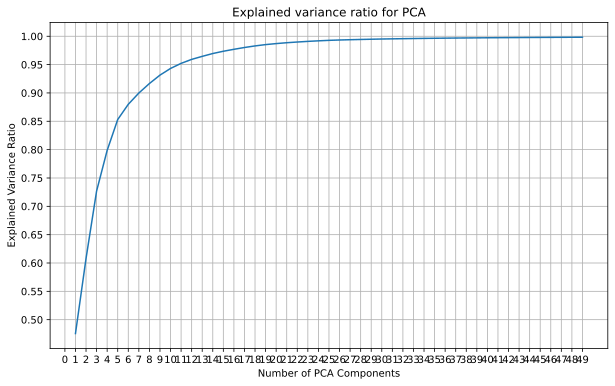

In [18]:
from matplotlib import pyplot as plt
candidate_components = range(1,50,1)
explained_ratios =[]

for c in candidate_components:
    pca = PCA(n_components=c)
    X_pca = pca.fit_transform(LBP_dataset)
    explained_ratios.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize=(10,6), dpi=144)
plt.grid()
plt.plot(candidate_components, explained_ratios)
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained variance ratio for PCA')
plt.yticks(np.arange(0.5,1.05,.05))
plt.xticks(np.arange(0,50,1))

In [7]:
# 选择80个主成分 还原率保证大于95%
pca = PCA(n_components=80)
X_pca_HOF = pca.fit_transform(HOF_dataset)
X_pca_HOF.shape

(150, 80)

In [12]:
X_pca_HOF

array([[-0.62054931, -0.21397288,  0.2022454 , ...,  0.04411346,
        -0.06835749, -0.0296996 ],
       [-0.58925097, -0.16994506,  0.21838462, ..., -0.06687286,
        -0.01998204,  0.01737168],
       [-0.67248453, -0.18667472,  0.24375848, ..., -0.04768096,
         0.05256824, -0.02106306],
       ...,
       [ 0.82647691,  0.40457483, -0.11126606, ...,  0.02136749,
         0.00922532, -0.04246503],
       [ 0.92004096,  0.41531442,  0.01749209, ..., -0.0568226 ,
        -0.01979005,  0.0062042 ],
       [ 0.67732155,  0.17899402, -0.09499091, ...,  0.02804329,
         0.02721128, -0.01040438]])

In [8]:
pca = PCA(n_components=11)
X_pca_LBP = pca.fit_transform(LBP_dataset)
X_pca_LBP.shape

(150, 11)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
new_X_pca_LBP = scaler.fit_transform(X_pca_LBP)
new_X_pca_LBP

array([[ 0.58633715, -0.602213  , -1.1203742 , ..., -1.3162572 ,
        -1.4752647 ,  1.3516488 ],
       [ 0.882221  , -0.5488312 , -0.98782927, ...,  1.0980021 ,
        -0.34846264, -0.03167756],
       [ 0.38805547, -0.76244074, -1.1034224 , ..., -0.23576646,
        -0.9827248 ,  0.4548516 ],
       ...,
       [ 0.00220496, -0.49538678,  1.5732619 , ...,  0.63173246,
         1.1775937 , -0.70329183],
       [-0.03533535, -0.97793645,  1.2475114 , ...,  0.5138041 ,
         1.4848937 ,  0.26817247],
       [ 0.22561768, -0.2532138 ,  1.2353686 , ..., -0.90748006,
         1.2549967 ,  0.38103577]], dtype=float32)

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
new_X_pca_HOF = scaler.fit_transform(X_pca_HOF)
new_X_pca_HOF

array([[-1.4854928 , -0.57599706,  0.68743474, ...,  0.95021529,
        -1.48383075, -0.66312743],
       [-1.41056974, -0.45747785,  0.74229215, ..., -1.44045868,
        -0.43374867,  0.38787176],
       [-1.60981717, -0.50251271,  0.82853823, ..., -1.0270602 ,
         1.14109482, -0.47029237],
       ...,
       [ 1.97844957,  1.08908153, -0.37819476, ...,  0.46026128,
         0.2002534 , -0.94815172],
       [ 2.20242647,  1.11799161,  0.05945585, ..., -1.22397349,
        -0.42958102,  0.13852631],
       [ 1.62139621,  0.48183689, -0.32287534, ...,  0.60405985,
         0.59067317, -0.23230711]])

In [24]:
merge_all = np.concatenate((new_X_pca_HOF,new_X_pca_LBP),axis=1)
print(merge_all.shape)

(150, 91)


In [33]:
merge_all_origin = np.concatenate((HOF_dataset,LBP_dataset),axis=1)
print(merge_all_origin.shape)

(150, 9948)


In [16]:
from sklearn.model_selection import train_test_split

(trDat,
 vlDat,
 trLbl, 
 vlLbl) = train_test_split(X_pca_HOF,
               label,
               # Make sure the split is applied on each class
               stratify=label, 
               test_size=0.1,
               random_state=228,
               shuffle=True)
 
print("The shape of trDat is", trDat.shape)
print("The shape of vlDat is", vlDat.shape)
print("The shape of trlbl is", trLbl.shape)
print("The shape of vllbl is", vlLbl.shape)

The shape of trDat is (135, 20)
The shape of vlDat is (15, 20)
The shape of trlbl is (135,)
The shape of vllbl is (15,)


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parameters={'kernel':['linear','rbf','sigmoid','poly'],'C':np.linspace(0.1,20,50),'gamma':np.linspace(0.1,20,20)}

param_grid ={'C':[1,5,10,50,100],
'gamma':[0.0001,0.0005,0.001,0.005,0.01]}
# clf =GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), parameters)
# clf = clf.fit(trDat, trLbl)

svc = svm.SVC(kernel='linear')
model = GridSearchCV(svc,param_grid,cv=5,scoring='accuracy',verbose=2)
model.fit(X_pca,label)
print(model.best_params_, model.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................................C=1, gamma=0.0001; total time=   8.2s
[CV] END ..................................C=1, gamma=0.0001; total time=   7.2s
[CV] END ..................................C=1, gamma=0.0001; total time=  22.1s
[CV] END ..................................C=1, gamma=0.0001; total time=   2.4s
[CV] END ..................................C=1, gamma=0.0001; total time=  28.6s
[CV] END ..................................C=1, gamma=0.0005; total time=   9.4s
[CV] END ..................................C=1, gamma=0.0005; total time=   8.4s
[CV] END ..................................C=1, gamma=0.0005; total time=  27.4s
[CV] END ..................................C=1, gamma=0.0005; total time=   3.0s
[CV] END ..................................C=1, gamma=0.0005; total time=  33.6s
[CV] END ...................................C=1, gamma=0.001; total time=   9.3s
[CV] END ...................................C=1

In [27]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
count = 0
i = 0
y_pre = []
for train,test in loo.split(merge_all):
    print("loop: ", i)
    i=i+1
    #print(f'train index: {train} , test index: {test}')
    # print(f'train data: {HOF_dataset[train]} , test data: {HOF_dataset[test]}')
    print('--------------------')
    svm_model = svm.SVC(kernel = 'linear', C = 2).fit(merge_all[train],label[train])
    y_pred = svm_model.predict(merge_all[test])
    y_pre.append(y_pred)
    print("y_pred: ",y_pred)
    if y_pred == label[test]:
        count = count +1
print(count/150)
    

loop:  0
--------------------
y_pred:  [1]
loop:  1
--------------------
y_pred:  [0]
loop:  2
--------------------
y_pred:  [0]
loop:  3
--------------------
y_pred:  [3]
loop:  4
--------------------
y_pred:  [3]
loop:  5
--------------------
y_pred:  [1]
loop:  6
--------------------
y_pred:  [2]
loop:  7
--------------------
y_pred:  [2]
loop:  8
--------------------
y_pred:  [2]
loop:  9
--------------------
y_pred:  [2]
loop:  10
--------------------
y_pred:  [0]
loop:  11
--------------------
y_pred:  [3]
loop:  12
--------------------
y_pred:  [0]
loop:  13
--------------------
y_pred:  [2]
loop:  14
--------------------
y_pred:  [0]
loop:  15
--------------------
y_pred:  [0]
loop:  16
--------------------
y_pred:  [0]
loop:  17
--------------------
y_pred:  [0]
loop:  18
--------------------
y_pred:  [0]
loop:  19
--------------------
y_pred:  [0]
loop:  20
--------------------
y_pred:  [0]
loop:  21
--------------------
y_pred:  [1]
loop:  22
--------------------
y_pred:  [3

In [23]:
# only hoof
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(label, y_pre))
print(confusion_matrix(label, y_pre))

              precision    recall  f1-score   support

           0       0.68      0.79      0.74        63
           1       0.29      0.19      0.23        32
           2       0.28      0.26      0.27        27
           3       0.48      0.54      0.51        28

    accuracy                           0.52       150
   macro avg       0.43      0.44      0.43       150
weighted avg       0.49      0.52      0.50       150

[[50  2  2  9]
 [ 6  6 13  7]
 [ 8 12  7  0]
 [ 9  1  3 15]]


In [20]:
# only LBP
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(label, y_pre))
print(confusion_matrix(label, y_pre))

              precision    recall  f1-score   support

           0       0.49      0.78      0.60        63
           1       0.36      0.28      0.32        32
           2       0.42      0.19      0.26        27
           3       0.58      0.25      0.35        28

    accuracy                           0.47       150
   macro avg       0.46      0.37      0.38       150
weighted avg       0.46      0.47      0.43       150

[[49 10  2  2]
 [20  9  2  1]
 [16  4  5  2]
 [16  2  3  7]]


In [28]:
# only mix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(label, y_pre))
print(confusion_matrix(label, y_pre))

              precision    recall  f1-score   support

           0       0.67      0.78      0.72        63
           1       0.45      0.41      0.43        32
           2       0.38      0.33      0.35        27
           3       0.58      0.50      0.54        28

    accuracy                           0.57       150
   macro avg       0.52      0.50      0.51       150
weighted avg       0.55      0.57      0.56       150

[[49  5  5  4]
 [ 9 13  7  3]
 [ 6  9  9  3]
 [ 9  2  3 14]]


In [32]:
# only RF after PCA mix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(label, y_pre))
print(confusion_matrix(label, y_pre))

              precision    recall  f1-score   support

           0       0.46      0.95      0.62        63
           1       0.17      0.03      0.05        32
           2       0.50      0.07      0.13        27
           3       0.44      0.14      0.22        28

    accuracy                           0.45       150
   macro avg       0.39      0.30      0.25       150
weighted avg       0.40      0.45      0.33       150

[[60  0  0  3]
 [27  1  2  2]
 [21  4  2  0]
 [23  1  0  4]]


In [35]:
# only RF after PCA mix_origin
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(label, y_pre))
print(confusion_matrix(label, y_pre))

              precision    recall  f1-score   support

           0       0.56      0.92      0.69        63
           1       0.30      0.09      0.14        32
           2       0.47      0.30      0.36        27
           3       0.53      0.36      0.43        28

    accuracy                           0.53       150
   macro avg       0.46      0.42      0.41       150
weighted avg       0.48      0.53      0.47       150

[[58  0  0  5]
 [18  3  8  3]
 [12  6  8  1]
 [16  1  1 10]]


### 6.2 LASSO 降维

In [48]:
merge_all.shape

(150, 9948)

### 6.3 Random Forest 降维

In [ ]:
# 调参: https://zhuanlan.zhihu.com/p/126288078

In [46]:
from sklearn.model_selection import train_test_split

(trDat,
 vlDat,
 trLbl, 
 vlLbl) = train_test_split(merge_all,
               label,
               # Make sure the split is applied on each class
               stratify=label, 
               test_size=0.2,
               random_state=228,
               shuffle=True)
 
print("The shape of trDat is", trDat.shape)
print("The shape of vlDat is", vlDat.shape)
print("The shape of trlbl is", trLbl.shape)
print("The shape of vllbl is", vlLbl.shape)

The shape of trDat is (120, 9948)
The shape of vlDat is (30, 9948)
The shape of trlbl is (120,)
The shape of vllbl is (30,)


In [114]:
HOF_dataset.shape
#label.shape

(150, 9180)

In [30]:
# 以下是对合并数据的随机森林
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [47]:
RFC = RandomForestClassifier(n_estimators=18,n_jobs= -1 ,random_state=1)
RFC.fit(merge_all,label)
#y_pred = RFC.predict(vlDat)
print("train score:",RFC.score(merge_all,label))
# print("test score:",RFC.score(vlDat,vlLbl))
# print(classification_report(vlLbl, y_pred))

train score: 1.0


In [112]:
# HOF
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators=7000,n_jobs= -1 ,random_state=0)
RFC.fit(trDat,trLbl)
y_pred = RFC.predict(vlDat)
print("train score:",RFC.score(trDat,trLbl))
print("test score:",RFC.score(vlDat,vlLbl))
print(classification_report(vlLbl, y_pred))

train score: 1.0
test score: 0.6
              precision    recall  f1-score   support

           0       0.62      1.00      0.76        13
           1       0.00      0.00      0.00         6
           2       0.40      0.40      0.40         5
           3       0.75      0.50      0.60         6

    accuracy                           0.60        30
   macro avg       0.44      0.47      0.44        30
weighted avg       0.48      0.60      0.52        30



D:\ProgramData\Anaconda3\envs\NUS_workshop\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\envs\NUS_workshop\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\envs\NUS_workshop\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
count = 0
i = 0
y_pre = []
for train,test in loo.split(merge_all):
    print("loop: ", i)
    i=i+1
    #print(f'train index: {train} , test index: {test}')
    # print(f'train data: {HOF_dataset[train]} , test data: {HOF_dataset[test]}')
    print('--------------------')
    RFC = RandomForestClassifier(n_estimators=5000,n_jobs= -1 ,random_state=0)
    RFC.fit(merge_all[train],label[train])
    #svm_model = svm.SVC(kernel = 'linear', C = 1.3183673469387756,gamma=0.1).fit(X_pca[train],label[train])
    y_pred = RFC.predict(merge_all[test])
    print("y_pred: ",y_pred)
    y_pre.append(y_pred)
    if y_pred == label[test]:
        count = count +1
print(count/150)
    

loop:  0
--------------------
y_pred:  [0]
loop:  1
--------------------
y_pred:  [0]
loop:  2
--------------------
y_pred:  [0]
loop:  3
--------------------
y_pred:  [0]
loop:  4
--------------------
y_pred:  [1]
loop:  5
--------------------
y_pred:  [2]
loop:  6
--------------------
y_pred:  [0]
loop:  7
--------------------
y_pred:  [0]
loop:  8
--------------------
y_pred:  [2]
loop:  9
--------------------
y_pred:  [1]
loop:  10
--------------------
y_pred:  [0]
loop:  11
--------------------
y_pred:  [0]
loop:  12
--------------------
y_pred:  [0]
loop:  13
--------------------
y_pred:  [0]
loop:  14
--------------------
y_pred:  [0]
loop:  15
--------------------
y_pred:  [0]
loop:  16
--------------------
y_pred:  [0]
loop:  17
--------------------
y_pred:  [0]
loop:  18
--------------------
y_pred:  [0]
loop:  19
--------------------
y_pred:  [0]
loop:  20
--------------------
y_pred:  [0]
loop:  21
--------------------
y_pred:  [3]
loop:  22
--------------------
y_pred:  [0

In [34]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
count = 0
i = 0
y_pre = []
for train,test in loo.split(merge_all_origin):
    print("loop: ", i)
    i=i+1
    #print(f'train index: {train} , test index: {test}')
    # print(f'train data: {HOF_dataset[train]} , test data: {HOF_dataset[test]}')
    print('--------------------')
    RFC = RandomForestClassifier(n_estimators=5000,n_jobs= -1 ,random_state=0)
    RFC.fit(merge_all_origin[train],label[train])
    #svm_model = svm.SVC(kernel = 'linear', C = 1.3183673469387756,gamma=0.1).fit(X_pca[train],label[train])
    y_pred = RFC.predict(merge_all_origin[test])
    print("y_pred: ",y_pred)
    y_pre.append(y_pred)
    if y_pred == label[test]:
        count = count +1
print(count/150)
    

loop:  0
--------------------
y_pred:  [0]
loop:  1
--------------------
y_pred:  [0]
loop:  2
--------------------
y_pred:  [0]
loop:  3
--------------------
y_pred:  [3]
loop:  4
--------------------
y_pred:  [2]
loop:  5
--------------------
y_pred:  [2]
loop:  6
--------------------
y_pred:  [2]
loop:  7
--------------------
y_pred:  [2]
loop:  8
--------------------
y_pred:  [2]
loop:  9
--------------------
y_pred:  [2]
loop:  10
--------------------
y_pred:  [3]
loop:  11
--------------------
y_pred:  [0]
loop:  12
--------------------
y_pred:  [0]
loop:  13
--------------------
y_pred:  [0]
loop:  14
--------------------
y_pred:  [0]
loop:  15
--------------------
y_pred:  [0]
loop:  16
--------------------
y_pred:  [0]
loop:  17
--------------------
y_pred:  [0]
loop:  18
--------------------
y_pred:  [0]
loop:  19
--------------------
y_pred:  [0]
loop:  20
--------------------
y_pred:  [3]
loop:  21
--------------------
y_pred:  [3]
loop:  22
--------------------
y_pred:  [3

In [102]:
# import_level = RFC.feature_importances_ #这个方法可以调取关于特征重要程度
# # x_columns = data.columns[1:]
# index = np.argsort(import_level)[::-1]
# for each in range(HOF_dataset.shape[1]):
#     print('The important level of ' + str(import_level[index[each]]))


MemoryError: Unable to allocate 1.03 GiB for an array with shape (15000, 9180) and data type float64

In [49]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
# 建立随机森林
rfc = RandomForestClassifier(n_estimators=5000, random_state=90)

# 用交叉验证计算得分
score_pre = cross_val_score(rfc, merge_all, label, cv=10).mean()
score_pre

0.4066666666666666

最大得分：0.4333333333333334 子树数量为：21


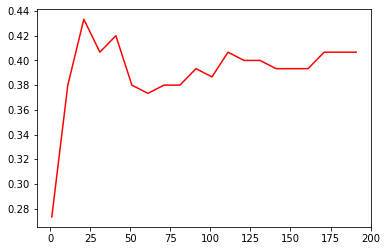

In [49]:
# 调参，绘制学习曲线来调参n_estimators（对随机森林影响最大）
score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(0,200,10):
    rfc = RandomForestClassifier(n_estimators=i+1
                                ,random_state=90)
    score = cross_val_score(rfc, merge_all, label, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+1))

# 绘制学习曲线
x = np.arange(1,201,10)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

In [ ]:
# 在41附近缩小n_estimators的范围为30-49
score_lt = []
for i in range(20,30):
    rfc = RandomForestClassifier(n_estimators=i
                                ,random_state=90)
    score = cross_val_score(rfc, merge_all, label, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)+30))

# 绘制学习曲线
x = np.arange(30,50)
plt.subplot(111)
plt.plot(x, score_lt,'o-')
plt.show()

In [ ]:
# 建立n_estimators为45的随机森林
rfc = RandomForestClassifier(n_estimators=45, random_state=90)

# 用网格搜索调整max_depth
param_grid = {'max_depth':np.arange(1,20)}
GS = GridSearchCV(rfc, param_grid, cv=10)
GS.fit(merge_all, label)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score)